## Beer style prediction using user rating criteria 
#### Priya Ramakrishnan

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
import category_encoders as ce

from src.data.sets import split_sets_random, save_sets
from src.models.null import NullModel
from src.models.performance import print_class_perf

import torch
import torch.nn as nn
import torch.nn.functional as F

from src.models.pytorch import PytorchMultiClass
from src.models.pytorch import get_device
from src.models.pytorch import train_classification, test_classification
from src.models.pytorch import PytorchDataset

In [4]:
#importing data 
df = pd.read_csv('../data/raw/beer_reviews.csv')

In [5]:
#### Exploring data 
df.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


In [5]:
df.shape

(1586614, 13)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586614 entries, 0 to 1586613
Data columns (total 13 columns):
brewery_id            1586614 non-null int64
brewery_name          1586599 non-null object
review_time           1586614 non-null int64
review_overall        1586614 non-null float64
review_aroma          1586614 non-null float64
review_appearance     1586614 non-null float64
review_profilename    1586266 non-null object
beer_style            1586614 non-null object
review_palate         1586614 non-null float64
review_taste          1586614 non-null float64
beer_name             1586614 non-null object
beer_abv              1518829 non-null float64
beer_beerid           1586614 non-null int64
dtypes: float64(6), int64(3), object(4)
memory usage: 157.4+ MB


In [7]:
df.describe()

,brewery_id,review_time,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid
count,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.518829e+06,1.586614e+06
mean,3.130099e+03,1.224089e+09,3.815581e+00,3.735636e+00,3.841642e+00,3.743701e+00,3.792860e+00,7.042387e+00,2.171279e+04
std,5.578104e+03,7.654427e+07,7.206219e-01,6.976167e-01,6.160928e-01,6.822184e-01,7.319696e-01,2.322526e+00,2.181834e+04
min,1.000000e+00,8.406720e+08,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,3.000000e+00
25%,1.430000e+02,1.173224e+09,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,5.200000e+00,1.717000e+03
50%,4.290000e+02,1.239203e+09,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,6.500000e+00,1.390600e+04
75%,2.372000e+03,1.288568e+09,4.500000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.500000e+00,8.500000e+00,3.944100e+04
max,2.800300e+04,1.326285e+09,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.770000e+01,7.731700e+04


In [ ]:
df.nunique()

Analysis:
- There are 104 styles of beer <br> 
- 5742 breweries with 56,857 beer names
- We can also note that brewery_id and brewery_name are not the same numbers ie for some breweries have multiple ids (could be different breweries belonging to the same company).
- From below, the style American IPA has the most reviews 

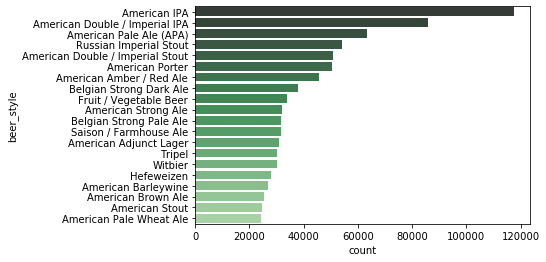

In [55]:
#getting to know the categegory variables - beer style
sns.countplot(y='beer_style',data=df,order=df.beer_style.value_counts().iloc[:20].index, palette='Greens_d')
plt.show()

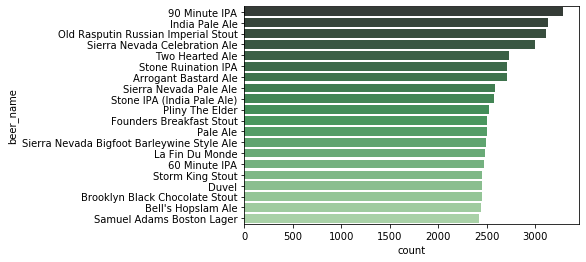

In [56]:
#getting to know the categegory variables - beer name
sns.countplot(y='beer_name',data=df,order=df.beer_name.value_counts().iloc[:20].index, palette='Greens_d')
plt.show()

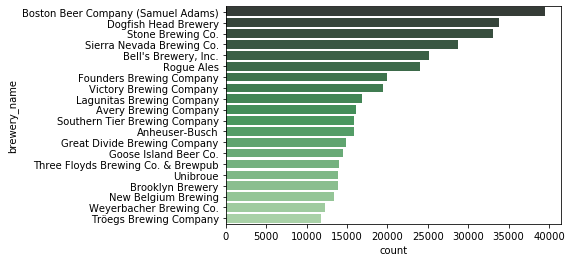

In [54]:
#getting to know the categegory variables - brewery name
sns.countplot(y='brewery_name',data=df,order=df.brewery_name.value_counts().iloc[:20].index, palette='Greens_d')
plt.show()

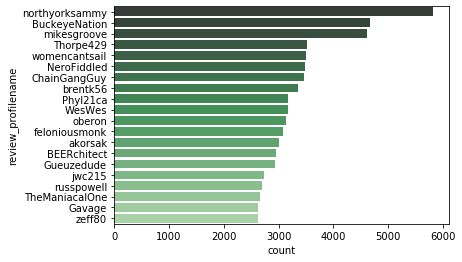

In [57]:
#getting to know the categegory variables - review profilename
sns.countplot(y='review_profilename',data=df,order=df.review_profilename.value_counts().iloc[:20].index, palette='Greens_d')
plt.show()

##### Checking if there are any null values: (the previous experiment didn't do so well as I did not check null values)
From below, brewery_name, review_profilename, beer_abv have null values

No. of null values: <br>
brewery name = 15 <br>
review_appearance = 348  <br>
beer_abv = 67785 <br>

In [56]:
df.isnull().any()

brewery_id            False
brewery_name           True
review_time           False
review_overall        False
review_aroma          False
review_appearance     False
review_profilename     True
beer_style            False
review_palate         False
review_taste          False
beer_name             False
beer_abv               True
beer_beerid           False
dtype: bool

In [58]:
len(df[df['brewery_name'].isnull()])

15

In [59]:
len(df[df['beer_abv'].isnull()])

67785

In [60]:
len(df[df['review_profilename'].isnull()])

348

##### Data cleaning - removing/replacing null values:

In [6]:
df_cleaned = df.copy()

In [7]:
#replace null brewery names with 'No brewery'
df_cleaned['brewery_name'].fillna("No brewery", inplace = True)

In [8]:
#replace null reviews profile name with 'No review'
df_cleaned['review_profilename'].fillna("No review", inplace = True)

In [9]:
#replace null beer_abv with mean
df_cleaned['beer_abv'].fillna((df['beer_abv'].mean()),inplace = True)

In [10]:
df_cleaned.describe()

,brewery_id,review_time,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid
count,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06
mean,3.130099e+03,1.224089e+09,3.815581e+00,3.735636e+00,3.841642e+00,3.743701e+00,3.792860e+00,7.042387e+00,2.171279e+04
std,5.578104e+03,7.654427e+07,7.206219e-01,6.976167e-01,6.160928e-01,6.822184e-01,7.319696e-01,2.272372e+00,2.181834e+04
min,1.000000e+00,8.406720e+08,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,3.000000e+00
25%,1.430000e+02,1.173224e+09,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,5.300000e+00,1.717000e+03
50%,4.290000e+02,1.239203e+09,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,6.600000e+00,1.390600e+04
75%,2.372000e+03,1.288568e+09,4.500000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.500000e+00,8.400000e+00,3.944100e+04
max,2.800300e+04,1.326285e+09,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.770000e+01,7.731700e+04


#### Prepare data

In [11]:
df_cleaned.drop(['beer_beerid'], axis=1, inplace=True)

In [12]:
#cannot use one hot encoding as the cardinality is high
#encoding target column using label encode
labelencoder = LabelEncoder()
df_cleaned['beer_style_enc'] = labelencoder.fit_transform(df_cleaned['beer_style'])

In [13]:
#instead of using brewery name, we can use brewery_id due to the many to one mapping 

#this label encoding for brewery id did not work at all!!!!! 
#df_cleaned['brewery_id'] = labelencoder.fit_transform(df_cleaned['brewery_id'])

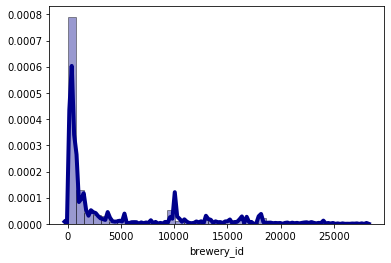

In [14]:
#there are 5840 brewery_ids.. what is the distribution of it? 
#do we need all of these to predict beer style? 

#might not be the correct plot for this? but looks nice
sns.distplot(df['brewery_id'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

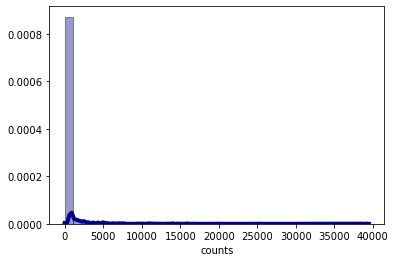

In [15]:
#the distribution is skewed - only few brewery_id's have most of the review - so may be we can remove or group some? 
df_brewery_id = df.groupby(['brewery_id']).size().reset_index(name='counts')
sns.distplot(df_brewery_id['counts'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [16]:
df_brewery_id[df_brewery_id['counts']>1000]

,brewery_id,counts
0,1,1357
2,3,5357
3,4,7321
6,8,3775
11,14,1202
...,...,...
4614,18968,1072
5000,22150,1044
5052,22511,1531
5120,22951,1334


In [17]:
#there are 269 brewery id's which have over 1000 ratings - retaining only those for this experiment
#replacing brewery id with 0 if the count is < 1000
#df_brewery_id['brewery_id_new'] = np.where(df_brewery_id['counts'] < 1000 ,0 , df_brewery_id['brewery_id'])
#df_brewery_id

In [18]:
#applying labelencoder to the remaining brewery_id - perhaps not needed - as the values are the same? 
#df_brewery_id['brewery_id_new_enc'] = labelencoder.fit_transform(df_brewery_id['brewery_id_new'])
#df_brewery_id.head()

In [19]:
brewery_id_feature = pd.DataFrame(df_cleaned['brewery_id'])

brewery_id_feature['counts']=brewery_id_feature.groupby('brewery_id')['brewery_id'].transform('count')
brewery_id_feature['brewery_id_new'] = np.where(brewery_id_feature['counts'] < 1000 ,0.0 , brewery_id_feature['brewery_id'])
brewery_id_feature

,brewery_id,counts,brewery_id_new
0,10325,4,0.0
1,10325,4,0.0
2,10325,4,0.0
3,10325,4,0.0
4,1075,889,0.0
...,...,...,...
1586609,14359,279,0.0
1586610,14359,279,0.0
1586611,14359,279,0.0
1586612,14359,279,0.0


In [20]:
brewery_id_feature['brewery_id_new'].nunique()

270

In [21]:
#target encoding from https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/
encoder=ce.TargetEncoder(cols = ['brewery_id_new']) 
brewery_id_feature['brewery_id_new_enc'] = encoder.fit_transform(brewery_id_feature['brewery_id_new'], df_cleaned['beer_style_enc'])
brewery_id_feature['brewery_id_new_enc']

0          41.751765
1          41.751765
2          41.751765
3          41.751765
4          41.751765
             ...    
1586609    41.751765
1586610    41.751765
1586611    41.751765
1586612    41.751765
1586613    41.751765
Name: brewery_id_new_enc, Length: 1586614, dtype: float64

In [22]:
#joining back to original df
df_cleaned['brewery_id_new_enc'] = brewery_id_feature['brewery_id_new_enc']
df_cleaned['brewery_id_new'] = brewery_id_feature['brewery_id_new']

In [20]:
df_cleaned.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_style_enc,brewery_id_new_enc,brewery_id_new
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,65,41.751765,0.0
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,51,41.751765,0.0
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,59,41.751765,0.0
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,61,41.751765,0.0
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,9,41.751765,0.0


In [23]:
num_cols = ['review_aroma', 'review_appearance', 'review_palate', 'review_taste']
cat_cols = ['brewery_name','review_profilename','beer_name','beer_style']

In [ ]:
#standardising numerical columns
sc = StandardScaler()
df_cleaned[num_cols] = sc.fit_transform(df_cleaned[num_cols])

In [2]:
#dropping cat_cols
df_cleaned.drop(cat_cols, axis=1, inplace=True)
#df_cleaned.drop('beer_abv', axis=1, inplace=True)

NameError: name 'df_cleaned' is not defined

In [36]:
df_cleaned.nunique()

brewery_id              5840
review_time          1577960
review_overall            10
review_aroma               9
review_appearance         10
review_palate              9
review_taste               9
beer_abv                 530
beer_style_enc           104
dtype: int64

In [37]:
df_cleaned.head()

,brewery_id,review_time,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_style_enc
0,1.289847,0.140161,-3.213310,-2.487952,-2.177663,-3.288833,-3.132454,-0.879382,65
1,1.289847,0.154496,-1.131774,-1.771225,-1.366096,-1.090123,-1.083188,-0.362703,51
2,1.289847,0.154516,-1.131774,-1.771225,-1.366096,-1.090123,-1.083188,-0.233533,59
3,1.289847,0.138951,-1.131774,-1.054499,-0.554530,-1.823026,-1.083188,-0.879382,61
4,-0.368423,0.909878,0.255917,1.095679,0.257037,0.375684,0.966078,0.283146,9


In [38]:
#Split the data into training and testing sets with 80-20 ratio
X_train, y_train, X_val, y_val, X_test, y_test = split_sets_random(df_cleaned, target_col='beer_style_enc', test_ratio=0.2)

In [39]:
#Save the sets in the data/processed/beer_reviews folder
save_sets(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, X_test=X_test, y_test=y_test, path='../data/processed/beer_reviews/')

In [40]:
train_dataset = PytorchDataset(X=X_train, y=y_train)
val_dataset = PytorchDataset(X=X_val, y=y_val)
test_dataset = PytorchDataset(X=X_test, y=y_test)

#### Baseline Model

In [41]:
baseline_model = NullModel(target_type='classification')
y_base = baseline_model.fit_predict(y_train)

In [42]:
print_class_perf(y_base, y_train, set_name='Training', average='weighted')

Accuracy Training: 0.0742157299405022
F1 Training: 0.01025487603110527


#### Define Architecture

In [43]:
model = PytorchMultiClass(X_train.shape[1])

In [44]:
X_train.shape[1]

8

In [45]:
device = get_device()
model.to(device)

PytorchMultiClass(
  (layer_1): Linear(in_features=8, out_features=32, bias=True)
  (layer_out): Linear(in_features=32, out_features=104, bias=True)
  (softmax): Softmax(dim=1)
)

In [46]:
 print(model)

PytorchMultiClass(
  (layer_1): Linear(in_features=8, out_features=32, bias=True)
  (layer_out): Linear(in_features=32, out_features=104, bias=True)
  (softmax): Softmax(dim=1)
)


#### Train model

In [47]:
criterion = nn.CrossEntropyLoss()

In [48]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [49]:
N_EPOCHS = 4
BATCH_SIZE = 32

In [50]:
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train_classification(train_dataset, model=model, criterion=criterion, optimizer=optimizer, batch_size=BATCH_SIZE, device=device)
    valid_loss, valid_acc = test_classification(val_dataset, model=model, criterion=criterion, batch_size=BATCH_SIZE, device=device)

    print(f'Epoch: {epoch}')
    print(f'\t(train)\t|\tLoss: {train_loss:.4f}\t|\tAcc: {train_acc * 100:.1f}%')
    print(f'\t(valid)\t|\tLoss: {valid_loss:.4f}\t|\tAcc: {valid_acc * 100:.1f}%')

Epoch: 0
	(train)	|	Loss: nan	|	Acc: 0.5%
	(valid)	|	Loss: nan	|	Acc: 0.5%
Epoch: 1
	(train)	|	Loss: nan	|	Acc: 0.5%
	(valid)	|	Loss: nan	|	Acc: 0.5%
Epoch: 2
	(train)	|	Loss: nan	|	Acc: 0.5%
	(valid)	|	Loss: nan	|	Acc: 0.5%
Epoch: 3
	(train)	|	Loss: nan	|	Acc: 0.5%
	(valid)	|	Loss: nan	|	Acc: 0.5%


In [76]:
torch.save(model, "../models/pytorch_beer_9.5.pt")

In [78]:
test_loss, test_acc = test_classification(test_dataset, model=model, criterion=criterion, batch_size=BATCH_SIZE, device=device)
print(f'\tLoss: {test_loss:.4f}\t|\tAccuracy: {test_acc:.1f}')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x32 and 7x32)